In [1]:
#when in doubt, import it all
import math
import csv
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.metrics as skl
import csv
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_mldata
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import classification_report
from sklearn import metrics, cross_validation


/Users/patrickb/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/Users/patrickb/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


In [2]:
df=pd.read_csv('train.csv', sep=',')
df_test = pd.read_csv('test.csv')

continuous = ['Elevation', 'Aspect', 'Slope',
       'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
       'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
       'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points'
]
discrete = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
       'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
       'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
       'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
       'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
       'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
       'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
       'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
       'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
       'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
       'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'
]
predictors = continuous + discrete

target = ['Cover_Type']

In [3]:
train_set, dev_set = cross_validation.train_test_split(df,test_size=.25, random_state = 42)
X_train = train_set[predictors]
X_dev = dev_set[predictors]
y_train = train_set[target]
y_dev = dev_set[target]

In [4]:
#fit log model
lr = LogisticRegression(penalty='l2')
#c values to be tested
c = {'C': [0.01, 0.1, 0.5, 1.0, 2.0]}

gs = GridSearchCV(estimator=lr, param_grid=c)
gs.fit(X_train, y_train.values.ravel())
f1 = metrics.f1_score(y_dev, gs.predict(X_dev), average='weighted')

print('Best C:', gs.best_estimator_.C)
print('Accuracy:', gs.best_score_ )
print('F1:', f1)

Best C: 0.1
Accuracy: 0.667636684303351
F1: 0.6573110112114874


In [5]:
lr = LogisticRegression(penalty='l2', C=0.1)
lr.fit(X_train, y_train.values.ravel())

cm = confusion_matrix(y_dev, lr.predict(X_dev))
print (cm)

[[324  86   3   0  41   2  64]
 [133 272  18   1 104  20  12]
 [  0   3 251  90  28 163   1]
 [  0   0  38 493   0  21   0]
 [ 20  92  41   0 348  26   0]
 [  0  13  91  60  65 302   0]
 [ 47   3   2   0   6   0 496]]


# Base Log Model


In [ ]:
lr = LogisticRegression(penalty='l2', C=0.1)
lr.fit(df[predictors], df[target].values.ravel())

pred = lr.predict(df_test[predictors])
ID = df_test.Id

data_out = []
for i in range(len(ID)):
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})
    
import csv
with open('base_log_model.csv', 'wt') as fout:
    cout = csv.DictWriter(fout, ['ID','Cover_Type'])
    cout.writeheader()
    cout.writerows(data_out)

# PCA

0.432291007430353
47


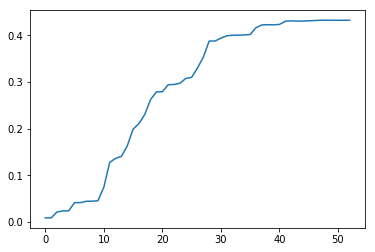

In [6]:
from sklearn.decomposition import PCA

def best_components(n_features):
    pca = PCA(n_components=n_features)
    X_transformed = pca.fit_transform(X_train)
    lr = LinearRegression()
    lr.fit(X_transformed, y_train)
    return lr.score(pca.transform(X_dev), y_dev)

out = [best_components(i) for i in range(1, 54)]

plt.plot(out)
print(np.max(out))
print(np.argmax(out))

In [13]:
pca = PCA(n_components= 47)
X_transformed = pca.fit_transform(X_train)
#fit log model
lr = LogisticRegression(penalty='l2')
#c values to be tested
c = {'C': [10.0, 11.0, 12.0, 13.0, 14.0]}

gs = GridSearchCV(estimator=lr, param_grid=c)
gs.fit(X_transformed, y_train.values.ravel())
f1 = metrics.f1_score(y_dev, gs.predict(pca.transform(X_dev)), average='weighted')

print('Best C:', gs.best_estimator_.C)
print('Accuracy:', gs.best_score_ )
print('F1:', f1)
#gave 11 but didnt like it C=2 works best

Best C: 11.0
Accuracy: 0.6729276895943562
F1: 0.6705900706858783


In [16]:
lr = LogisticRegression(penalty='l2', C=2.0)
lr.fit(X_transformed, df[target].values.ravel())

cm = confusion_matrix(y_dev, lr.predict(pca.transform(X_dev)))
print (cm)

[[340  83   3   0  45   1  48]
 [126 278  23   0 107  17   9]
 [  0   4 288  76  16 152   0]
 [  0   0  36 496   0  20   0]
 [ 13  58  54   0 379  23   0]
 [  0  15  91  56  51 318   0]
 [ 57   3   2   0   2   0 490]]


In [14]:
# df_test['Mean Hillshade'] = df_test[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
# df_test['log_elavation'] = np.log(df_test['Elevation'])

pca = PCA(n_components= 47)
X_transformed = pca.fit_transform(df[predictors])
lr = LogisticRegression(penalty='l2', C=2.0)
lr.fit(X_transformed, df[target].values.ravel())

pred = lr.predict(pca.transform(df_test[predictors]))
ID = df_test.Id

data_out = []

for i in range(len(ID)):
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})
    
fout = open('pkb_pca_exp3_runthrough.csv', 'wt') # <- best so far! 56% C=2.0 w/ PCA = 47 
cout = csv.DictWriter(fout, ['ID','Cover_Type'])
cout.writeheader()
cout.writerows(data_out)
fout.close()

In [ ]:
#Ignore
#Feature engineering

# df['Mean Hillshade'] = df[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
# df['log_elavation'] = np.log(df['Elevation'])
# df_test['Mean Hillshade'] = df_test[['Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm']].mean(axis=1)
# df_test['log_elavation'] = np.log(df_test['Elevation'])

# continuous = ['Elevation', 'Aspect', 'Slope',
#        'Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
#        'Horizontal_Distance_To_Roadways', 'Hillshade_9am', 'Hillshade_Noon',
#        'Hillshade_3pm', 'Horizontal_Distance_To_Fire_Points', 'Mean Hillshade', 'log_elavation'
# ]
# discrete = ['Wilderness_Area1', 'Wilderness_Area2', 'Wilderness_Area3',
#        'Wilderness_Area4', 'Soil_Type1', 'Soil_Type2', 'Soil_Type3',
#        'Soil_Type4', 'Soil_Type5', 'Soil_Type6', 'Soil_Type7', 'Soil_Type8',
#        'Soil_Type9', 'Soil_Type10', 'Soil_Type11', 'Soil_Type12',
#        'Soil_Type13', 'Soil_Type14', 'Soil_Type15', 'Soil_Type16',
#        'Soil_Type17', 'Soil_Type18', 'Soil_Type19', 'Soil_Type20',
#        'Soil_Type21', 'Soil_Type22', 'Soil_Type23', 'Soil_Type24',
#        'Soil_Type25', 'Soil_Type26', 'Soil_Type27', 'Soil_Type28',
#        'Soil_Type29', 'Soil_Type30', 'Soil_Type31', 'Soil_Type32',
#        'Soil_Type33', 'Soil_Type34', 'Soil_Type35', 'Soil_Type36',
#        'Soil_Type37', 'Soil_Type38', 'Soil_Type39', 'Soil_Type40'
# ]
# predictors = continuous + discrete

# target = ['Cover_Type']

X_train = df[predictors]
y_train = df[target]

pca = PCA(n_components= 47)
X_transformed = pca.fit_transform(X_train)
lr = LogisticRegression()
lr.fit(X_transformed, y_train.values.ravel())
# lr.score(pca.transform(X_dev), y_dev)

pred = lr.predict(pca.transform(df_test[predictors]))
ID = df_test.Id

data_out = []

for i in range(len(ID)):
    data_out.append({'ID':ID.iloc[i], 'Cover_Type':pred[i]})
    
fout = open('pkb_pca_log_exp4_wo_columns.csv', 'wt') 
cout = csv.DictWriter(fout, ['ID','Cover_Type'])
cout.writeheader()
cout.writerows(data_out)
fout.close()